<a href="https://colab.research.google.com/github/Akshitkt001/Bureau_Assignment/blob/main/Assignment_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DEALER ID                            10000 non-null  int64  
 1   APPLICATION LOGIN DATE               10000 non-null  object 
 2   HDB BRANCH NAME                      9999 non-null   object 
 3   HDB BRANCH STATE                     9146 non-null   object 
 4   FIRST NAME                           10000 non-null  object 
 5   MIDDLE NAME                          2855 non-null   object 
 6   LAST NAME                            9319 non-null   object 
 7   mobile                               10000 non-null  int64  
 8   AADHAR VERIFIED                      10000 non-null  object 
 9   Cibil Score                          5703 non-null   object 
 10  MOBILE VERIFICATION                  10000 non-null  bool   
 11  DEALER NAME                  

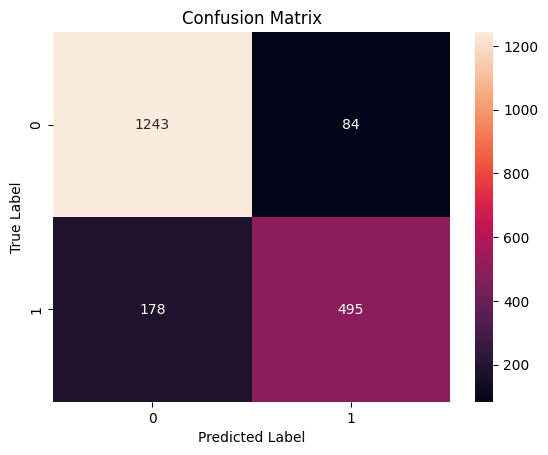

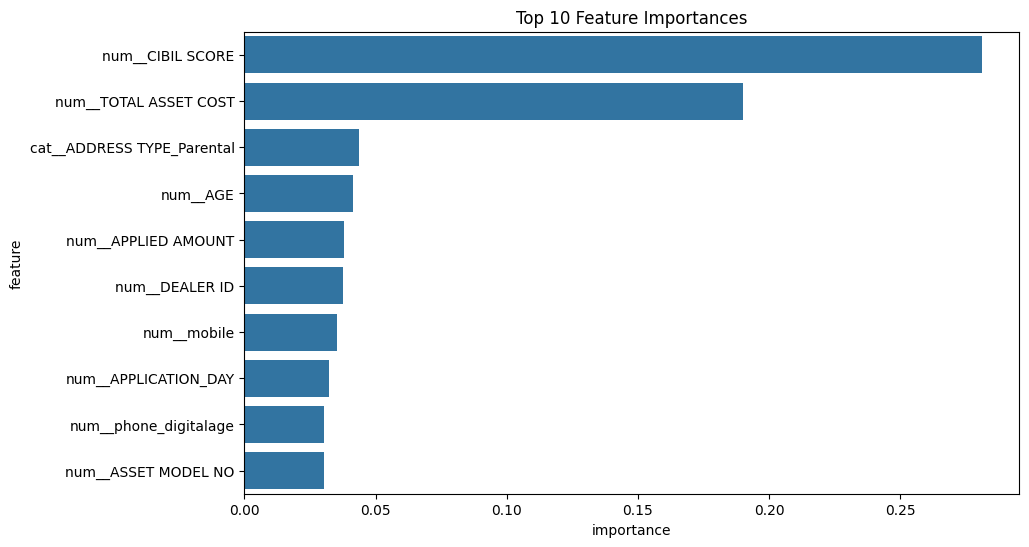

Predictions saved to predictions.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from dateutil.parser import parse

# Custom date parser function
def parse_date(date_str):
    try:
        return parse(date_str, dayfirst=False)
    except ValueError:
        try:
            return parse(date_str, dayfirst=True)
        except ValueError:
            return pd.NaT

# Loading data
train_data = pd.read_csv('Assignment_Train.csv')
test_data = pd.read_csv('Assignment_Test.csv')

# Basic data exploration
print(train_data.info())
print(train_data.describe())

# Handling missing values
train_data = train_data.fillna(train_data.mode().iloc[0])
test_data = test_data.fillna(test_data.mode().iloc[0])

# Feature
train_data['APPLICATION_LOGIN_DATE'] = train_data['APPLICATION LOGIN DATE'].apply(parse_date)
train_data['APPLICATION_MONTH'] = train_data['APPLICATION_LOGIN_DATE'].dt.month
train_data['APPLICATION_DAY'] = train_data['APPLICATION_LOGIN_DATE'].dt.day
train_data['APPLICATION_DAYOFWEEK'] = train_data['APPLICATION_LOGIN_DATE'].dt.dayofweek

test_data['APPLICATION_LOGIN_DATE'] = test_data['APPLICATION LOGIN DATE'].apply(parse_date)
test_data['APPLICATION_MONTH'] = test_data['APPLICATION_LOGIN_DATE'].dt.month
test_data['APPLICATION_DAY'] = test_data['APPLICATION_LOGIN_DATE'].dt.day
test_data['APPLICATION_DAYOFWEEK'] = test_data['APPLICATION_LOGIN_DATE'].dt.dayofweek

# Converting 'Cibil Score' to numeric, replacing non-numeric values with NaN
train_data['CIBIL SCORE'] = pd.to_numeric(train_data['Cibil Score'], errors='coerce')
test_data['CIBIL SCORE'] = pd.to_numeric(test_data['Cibil Score'], errors='coerce')

# features for model
numeric_features = ['DEALER ID', 'mobile', 'TOTAL ASSET COST', 'ASSET MODEL NO', 'APPLIED AMOUNT',
                    'AGE', 'APPLICATION_MONTH', 'APPLICATION_DAY', 'APPLICATION_DAYOFWEEK',
                    'CIBIL SCORE', 'phone_digitalage', 'phone_nameMatchScore']

categorical_features = ['AADHAR VERIFIED', 'MOBILE VERIFICATION', 'MARITAL STATUS', 'GENDER',
                        'ADDRESS TYPE', 'EMPLOY CONSTITUTION', 'EMPLOYER TYPE', 'PRIMARY ASSET MAKE']

boolean_features = ['Phone Social Premium.amazon', 'Phone Social Premium.byjus',
                    'Phone Social Premium.flipkart', 'Phone Social Premium.housing',
                    'Phone Social Premium.indiamart', 'Phone Social Premium.instagram',
                    'Phone Social Premium.isWABusiness', 'Phone Social Premium.jeevansaathi',
                    'Phone Social Premium.microsoft', 'Phone Social Premium.paytm',
                    'Phone Social Premium.shaadi', 'Phone Social Premium.skype',
                    'Phone Social Premium.toi', 'Phone Social Premium.whatsapp']

features = numeric_features + categorical_features + boolean_features

X = train_data[features]
y = train_data['Application Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features)
    ])

# Creating a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])

# Parameters for grid search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# grid search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# best model
best_model = grid_search.best_estimator_

# predictions on validation set
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

#classification report and ROC AUC score
print(classification_report(y_val, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred_proba)}")

# confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

# Make predictions on test set
test_predictions = best_model.predict(test_data[features])


submission = pd.DataFrame({
    'UID': test_data['UID'],
    'Prediction': test_predictions
})
submission.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")